# Test hybrid model

Test a hybrid neural network model which includes hourly and 1-minute data in the same model

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import (define_model_cnn_1_min, define_model_cnn_hourly, define_model_lstm_1_min, define_model_lstm_hourly, 
                               define_model_cnn_lstm_1_min, define_model_cnn_lstm_hourly, define_model_cnn_hybrid)
from preprocessing import combine_old_and_new_data
from predict import load_models, predict_batch
from train import train_nn_models, train_nn_hybrid_models
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [3]:
# user options
retrain_models = True # if true, train and save models, otherwise load pre-trained models from disk
model = "hybrid_cnn"

In [4]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [5]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = combine_old_and_new_data(solar_old, solar_train)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_test_hourly = combine_old_and_new_data(pd.DataFrame(), solar_test)

In [6]:
# train hybrid model
output_folder = os.path.join("trained_models", model, "benchmark")
output_folder_hourly = os.path.join("trained_models", model, "hourly_part", "benchmark")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_hourly, exist_ok=True)
if retrain_models:
    train_nn_hybrid_models(
            solar_train_hourly,
            solar_train,
            sunspots_train_hourly,
            dst_train_hourly,
            define_model_cnn_hybrid,
            1,
            output_folder,
            output_folder_hourly,
            early_stopping=True,
    )

Epoch 1/100
10936/10936 [==============================] - 36s 3ms/step - loss: 257.5498 - root_mean_squared_error: 15.9555 - val_loss: 201.0197 - val_root_mean_squared_error: 14.1781
Epoch 2/100
10936/10936 [==============================] - 33s 3ms/step - loss: 183.7003 - root_mean_squared_error: 13.5530 - val_loss: 197.6748 - val_root_mean_squared_error: 14.0597
Epoch 3/100
10936/10936 [==============================] - 33s 3ms/step - loss: 164.1487 - root_mean_squared_error: 12.8112 - val_loss: 197.4977 - val_root_mean_squared_error: 14.0534
Epoch 4/100
10936/10936 [==============================] - 33s 3ms/step - loss: 147.9740 - root_mean_squared_error: 12.1637 - val_loss: 199.8671 - val_root_mean_squared_error: 14.1374
Epoch 5/100
10936/10936 [==============================] - 33s 3ms/step - loss: 134.1630 - root_mean_squared_error: 11.5822 - val_loss: 199.3326 - val_root_mean_squared_error: 14.1185
Epoch 6/100
10936/10936 [==============================] - 33s 3ms/step - loss: 

In [7]:
# measure performance
output_folder = os.path.join("trained_models", model, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)

dst_test['timedelta'] = pd.to_timedelta(dst_test['timedelta'])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "hybrid"
)
dst_test = pd.merge(dst_test[['period', 'timedelta', 'dst']], predictions, "left", ["period", "timedelta"])
dst_test.sort_values(["period", "timedelta"], inplace=True)
dst_test["dst_t_plus_1"] = dst_test.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test["dst"].values, dst_test["prediction_t"].values)
)
valid_ind = dst_test["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 13.78
RMSE for time t+1: 13.79


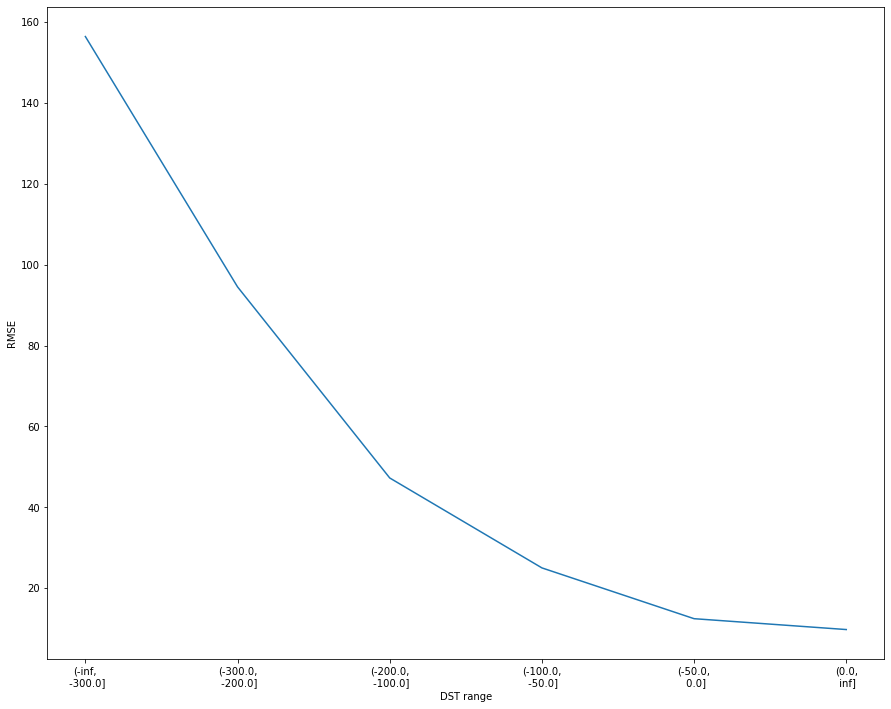

In [8]:
# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test.loc[valid_ind, "dst"].values, dst_test.loc[valid_ind, "prediction_t"].values, bins)


In [9]:
# size of ranges
bin_id = pd.cut(dst_test.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43218
"(0.0, inf]",12454


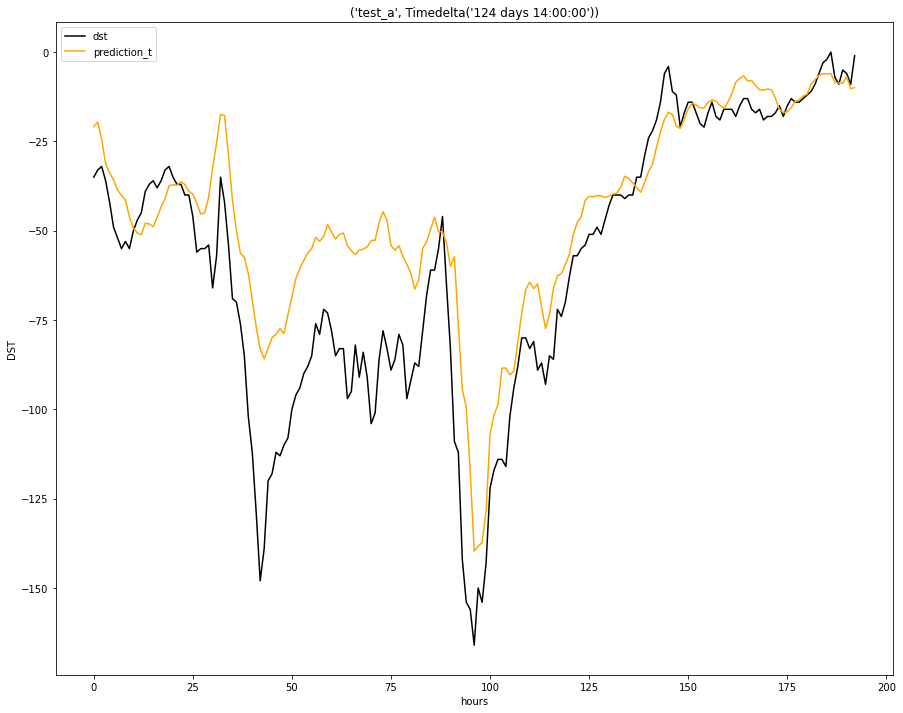

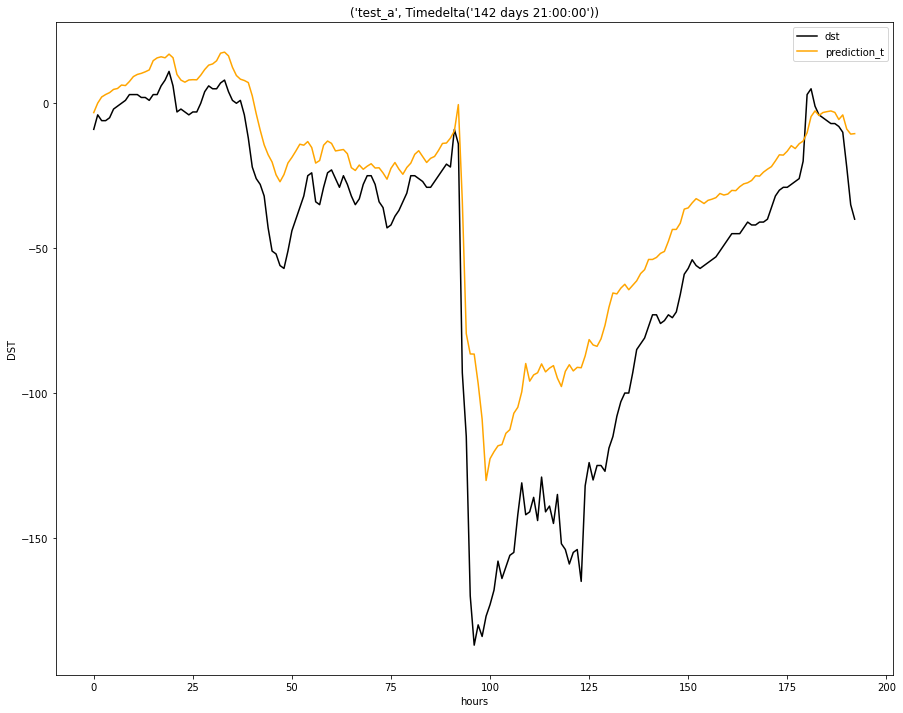

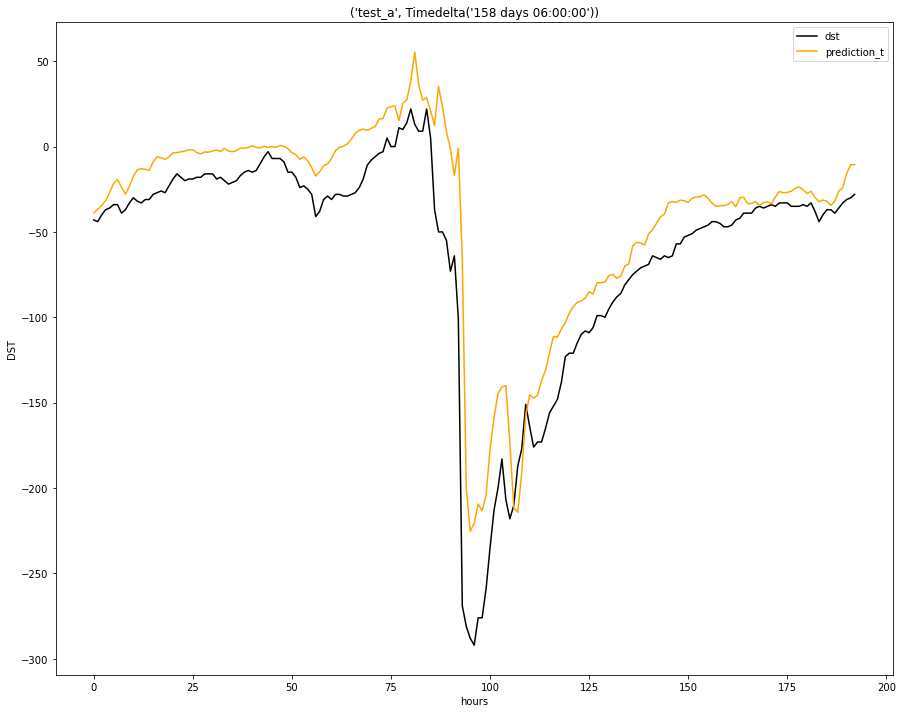

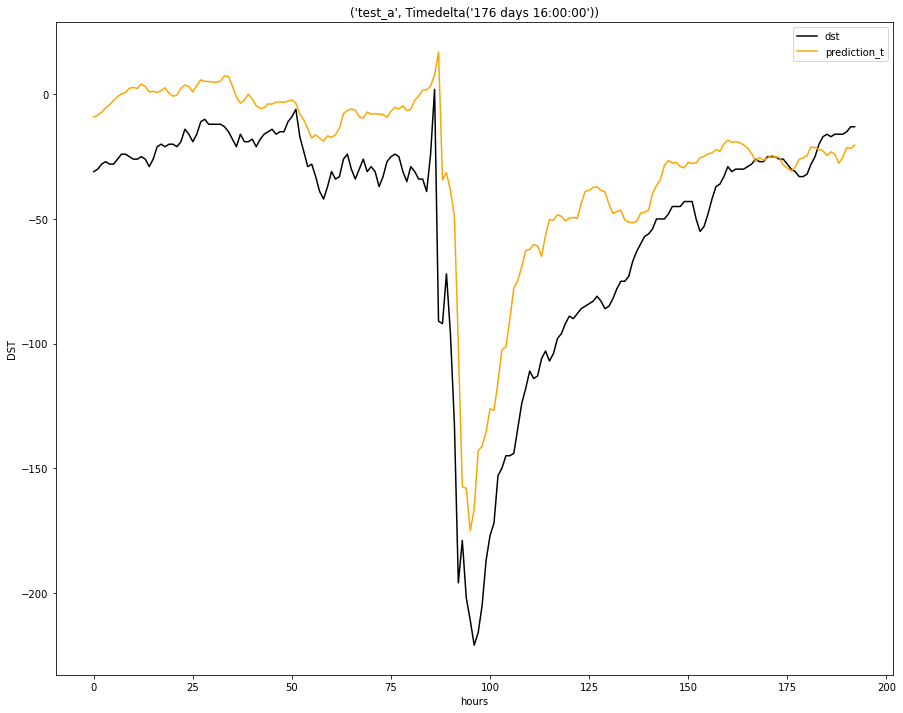

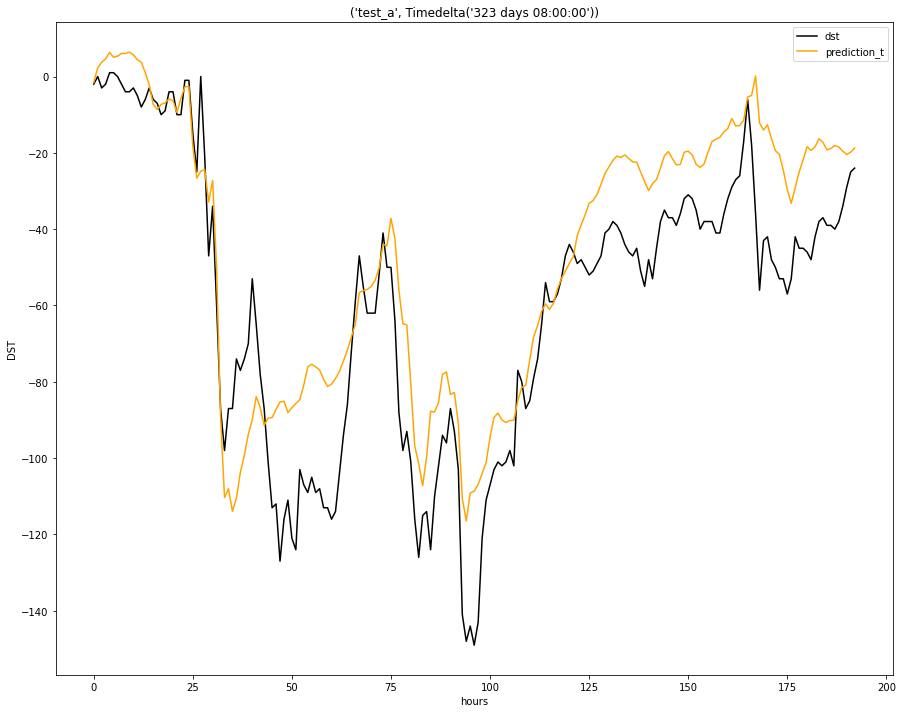

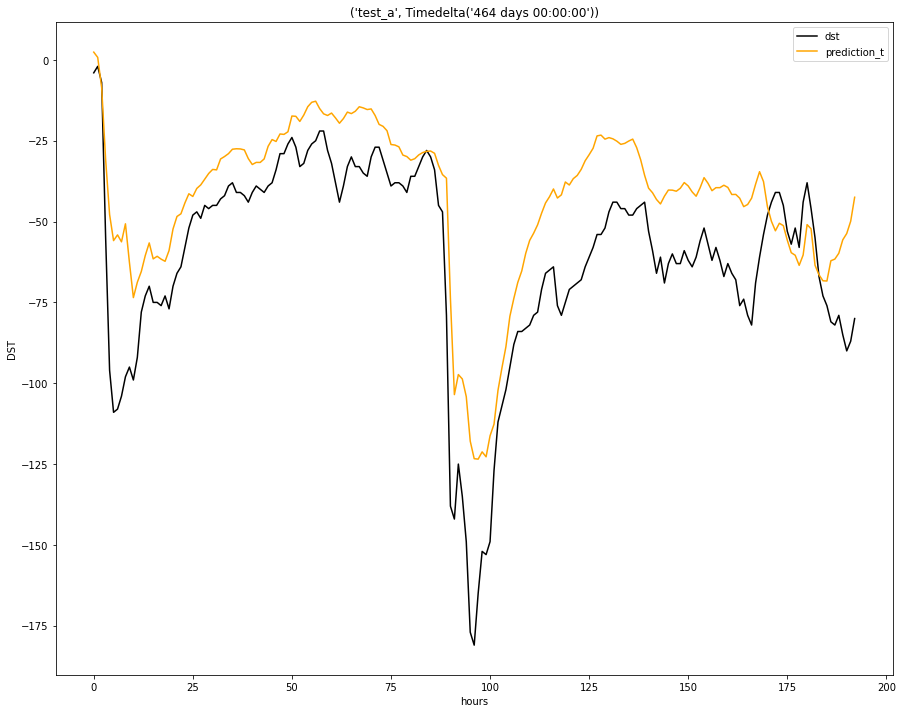

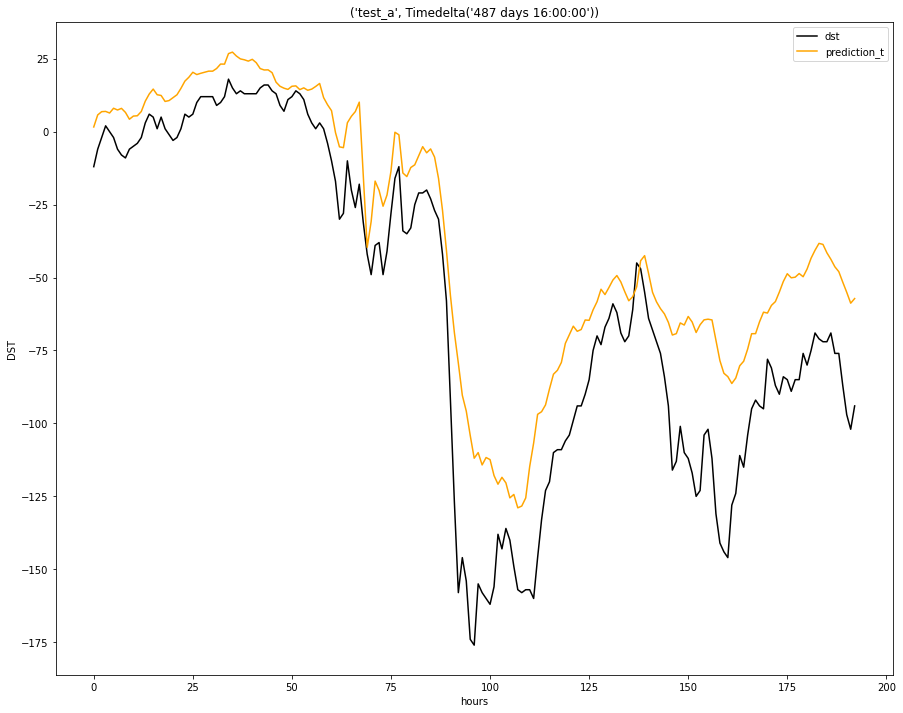

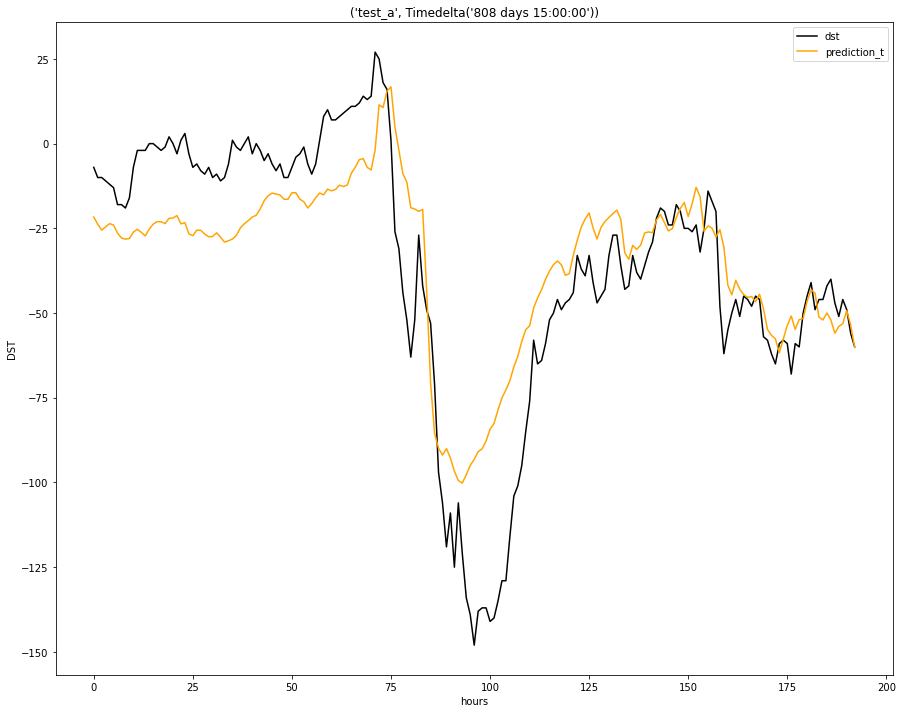

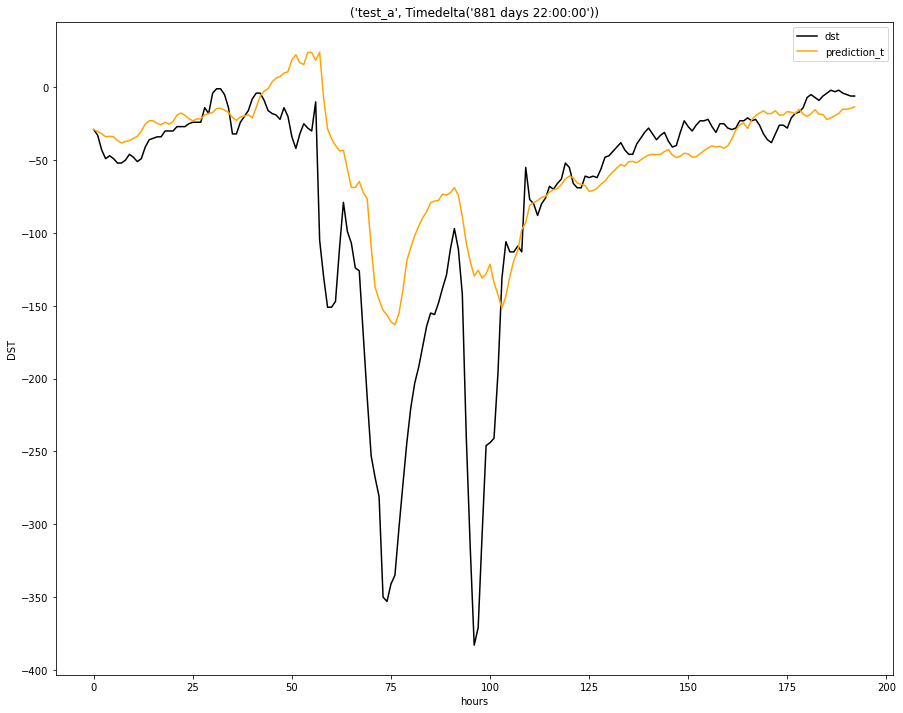

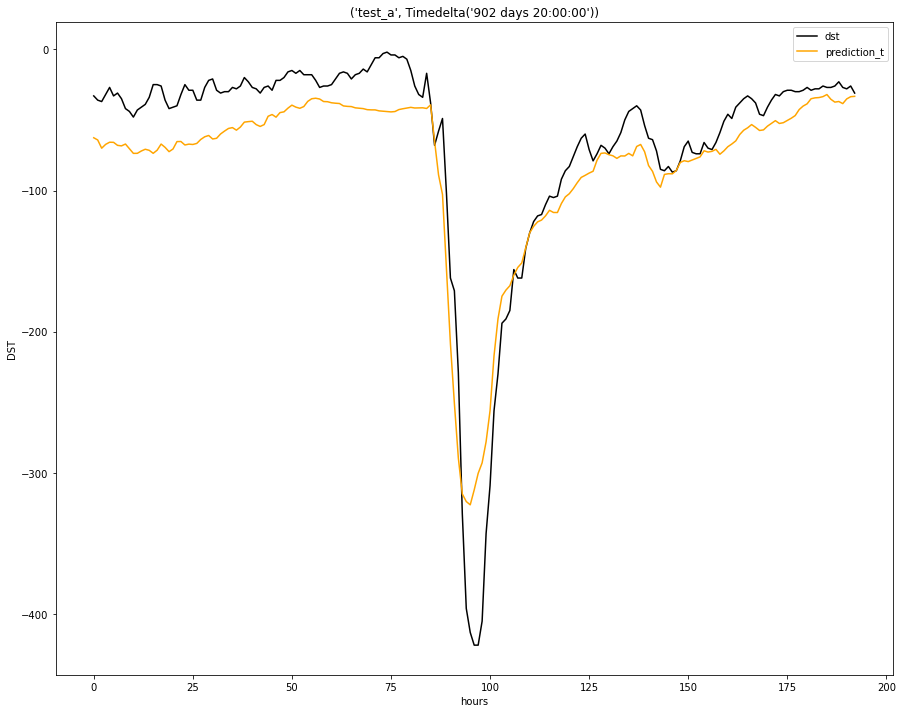

In [10]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_t"].values, c="orange")
    plt.legend(["dst", "prediction_t"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")

